In [108]:
using LinearAlgebra
using LaTeXStrings
using FFTW
t1 = 1.0  # hopping amplitude between nearest neighbours
t2 = 0.0  # hoppping amplitude between second nearest neighbours
t_fixed = true  # choose false for energy spectrum E(t)
t1 = t_fixed ? t1 : collect((range(0.0,t1,30))) 
t2 = t_fixed ? t2 : collect((range(0.0,t2,30)))  
t = [t1,t2]

D = 2.0  # crystal field coefficient
N = 50  # number of unit cells, even
V_fixed = true  # # choose false for energy spectrum E(V)
V = V_fixed ? 2.0 : collect(range(0.0,5.0,50))


using Plots
Plots.default(         # cosmetic settings, optional
    size=(840, 530),   
    tickfontsize=14,   # increase tick label size
    guidefontsize=16,  # increase axis label font size
    legendfontsize=14  # increase legend font size
)

In [109]:
#defining congruence class Z_N and Xbasically defining n in k=n*2pi/N 
struct Zn
    val::Int64
    Zn(a::Int64) = new(mod(a,N))
end

Base.:+(a::Zn, b::Zn) = Zn(mod(a.val + b.val, N))
Base.:-(a::Zn, b::Zn) = Zn(mod(a.val - b.val, N))

In [110]:
#function for getting appropriate index because of Julia indexing
index(a::Zn) = a.val + 1

index (generic function with 1 method)

In [111]:
#defining 1BZ wave-vectors, adding remaining constants from k=n*2pi/N later in calculations
K = Vector{Zn}(undef,N) # k-vector
for i in 1:N
    K[i] = Zn(i-1) # k lies in [0,2pi)
end
K_vals = [k.val for k in K]
shifted_K_vals = [k.val - N/2 for k in K]

50-element Vector{Float64}:
 -25.0
 -24.0
 -23.0
 -22.0
 -21.0
 -20.0
 -19.0
 -18.0
 -17.0
 -16.0
   ⋮
  16.0
  17.0
  18.0
  19.0
  20.0
  21.0
  22.0
  23.0
  24.0

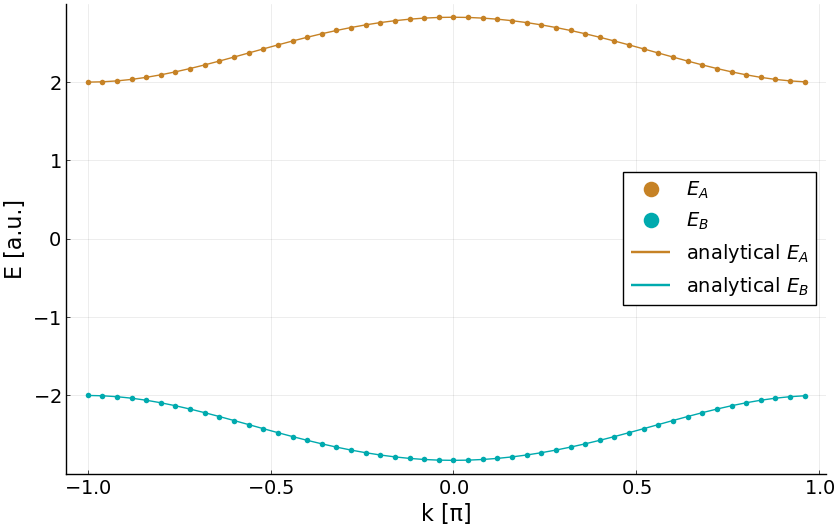

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [112]:
# defining non-interacting Hamiltonian for hopping to NN and NNN
h(N::Int64,K::Zn,t1::Float64,t2::Float64) = [-D t1*(1+exp(-im*2*pi/N*K.val)); t1*(1+exp(im*2*pi/N*K.val)) D] + 2*t2*[cos(K.val*2*pi/N) 0; 0 cos(K.val*2*pi/N)]

#defining function for diagonalizing non-interacting Hamiltonian and extracting band basis end energy dispersions
function eig_fun(N::Int64,K::Vector{Zn},h::Function,t1::Float64,t2::Float64) 
E_A = zeros(N)
E_B = zeros(N)
v_B = zeros(Complex{Float64},2,N)  # eigenvectors for B band 
v_A = zeros(Complex{Float64},2,N)  # eigenvectors for A band
a1 = zeros(Complex{Float64}, N)  # tranasform coefficients as defined in the thesis
b1 = zeros(Complex{Float64}, N) 
a2 = zeros(Complex{Float64}, N) 
b2 = zeros(Complex{Float64}, N)
    for i in 1:N  
        eig = eigen(h(N,K[i],t1,t2))  # diagonalizing for every k
        E_B[i] = eig.values[1]  # eigen() returns eigenvalues from lower to higher ones, so the first value is of the B band
        E_A[i] = eig.values[2]
        v_B[:,i] .= eig.vectors[:,1]  # eigenvectors are in columns and in the same order as eigenvalues
        v_A[:,i] .= eig.vectors[:,2] 
        b2[i] = v_B[1,i]  # coefficients extracting from U as in the thesis
        b1[i] = v_B[2,i]
        a2[i] = v_A[1,i]
        a1[i] = v_A[2,i]
    end
return E_A, E_B, b2, b1, a1, a2, v_A, v_B  # returning everything, but v_A and v_B is not necessarily needed
end

if t_fixed == true
band_structure = eig_fun(N,K,h,t[1],t[2])  # band structure in the ground state without interaction
E_A, E_B, b2, b1, a1, a2, v_A, v_B = band_structure




#plotting A and B bands
using Plots
pythonplot()
scatter(shifted_K_vals*2/N, fftshift(E_A), label  = L"E_A", markerstrokewidth=0, color=palette(:auto)[8])
scatter!(shifted_K_vals*2/N, fftshift(E_B), label = L"E_B", markerstrokewidth=0, color = palette(:auto)[6])
plot!(shifted_K_vals*2/N, 2*t[2]*cos.(shifted_K_vals*2*pi/N) + sqrt.(2*t[1]^2*(1 .+ cos.(shifted_K_vals*2*pi/N)) .+ D^2),label=L"\text{analytical } E_A", color=palette(:auto)[8]) #,legend_position=(0.37, 0.34)
plot!(shifted_K_vals*2/N, 2*t[2]*cos.(shifted_K_vals*2*pi/N) - sqrt.(2*t[1]^2*(1 .+ cos.(shifted_K_vals*2*pi/N)) .+ D^2), label=L"\text{analytical } E_B", color=palette(:auto)[6])
plot!(legend=:right)
xlabel!("k [π]")
ylabel!("E [a.u.]")
end

In [113]:
#defining matrix elements in the ground state
BBBB_0(K::Vector{Zn},a1,a2,b1,b2,X::Int64) = sum(abs2(b1[index(l)]) for l in K) * sum(abs2(b2[index(l)]) for l in K)

BAAB_0(K::Vector{Zn},a1,a2,b1,b2,X::Int64) = sum(exp(-im*X*q.val*2*pi/N) * conj(b1[index(l)]) * a1[index(l+q)] * conj(a2[index(l+q)]) * b2[index(l)] for l in K for q in K)

#defining diagonal matrix elements in the excited states
AAAA(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = conj(a1[index(k+Q)]) * a2[index(k+Q)] * sum(exp(-im*X*q.val*2*pi/N) * a1[index(k+Q+q)] * conj(a2[index(k+Q+q)]) for q in K)

ABBA(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = exp(im*X*Q.val*2*pi/N) * conj(a1[index(k+Q)]) * b1[index(k)] * conj(b2[index(k)]) * a2[index(k+Q)]

BBAA(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = abs2(a2[index(k+Q)]) * (sum(abs2(b1[index(l)]) for l in K) - abs2(b1[index(k)]))

AABB(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = abs2(a1[index(k+Q)]) * (sum(abs2(b2[index(l)]) for l in K) - abs2(b2[index(k)]))

BAAB(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = (a1[index(k+Q)] * conj(a2[index(k+Q)]) * (exp(-im*X*Q.val*2*pi/N) * conj(b1[index(k)]) * b2[index(k)] 
                                                    - sum(exp(im*X*q.val*2*pi/N) * conj(b1[index(k+Q+q)]) * b2[index(k+Q+q)] for q in K))
                                                    + sum(exp(-im*X*q.val*2*pi/N) * conj(b1[index(l)]) * a1[index(l+q)] * conj(a2[index(l+q)]) * b2[index(l)] for l in K for q in K)
                                                    - conj(b1[index(k)]) * b2[index(k)] * sum(exp(-im*X*q.val*2*pi/N) * a1[index(k+q)] * conj(a2[index(k+q)]) for q in K))

BBBB(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = (b1[index(k)] * conj(b2[index(k)]) * sum(exp(im*X*q.val*2*pi/N) * conj(b1[index(k+q)]) * b2[index(k+q)] for q in K)
                                                     - abs2(b2[index(k)]) * sum(abs2(b1[index(l)]) for l in K) - abs2(b1[index(k)]) * sum(abs2(b2[index(l)]) for l in K) 
                                                     + sum(abs2(b1[index(l)]) for l in K) * sum(abs2(b2[index(l)]) for l in K))

#defining offdiagonal matrix elements in the excited states
ABBAoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = exp(im*X*Q.val*2*pi/N) * conj(a1[index(k1+Q)]) * b1[index(k1)] * conj(b2[index(k2)]) * a2[index(k2+Q)]

BBAAoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = -exp(-im*X*(k1-k2).val*2*pi/N) * conj(b1[index(k2)]) * b1[index(k1)] * conj(a2[index(k1+Q)]) * a2[index(k2+Q)]

AABBoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = -exp(-im*X*(k2-k1).val*2*pi/N) * conj(a1[index(k1+Q)]) * a1[index(k2+Q)] * conj(b2[index(k2)]) * b2[index(k1)]

BAABoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,X::Int64) = exp(-im*X*Q.val*2*pi/N) * conj(b1[index(k2)]) * a1[index(k2+Q)] * conj(a2[index(k1+Q)]) * b2[index(k1)]

#defining occupation number operators in excited states
nak(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2) = 1/N*(abs2(a1[index(k+Q)]) + sum(abs2(b1[index(l)]) for l in K) - abs2(b1[index(k)]))
nbk(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2) =  1/N*(abs2(a2[index(k+Q)]) + sum(abs2(b2[index(l)]) for l in K) - abs2(b2[index(k)]))

nbk (generic function with 1 method)

In [114]:

# defining the diagonal contribution to the interaction Hamiltonian
function diagonal_interaction(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2)
    X_0 = (AAAA(K,k,Q,a1,a2,b1,b2,0) + ABBA(K,k,Q,a1,a2,b1,b2,0) + BBAA(K,k,Q,a1,a2,b1,b2,0) + AABB(K,k,Q,a1,a2,b1,b2,0) + BAAB(K,k,Q,a1,a2,b1,b2,0) 
        + BBBB(K,k,Q,a1,a2,b1,b2,0) - BBBB_0(K,a1,a2,b1,b2,0) - BAAB_0(K,a1,a2,b1,b2,0))  # interaction in the ground state must be subtracted
    X_1 = (AAAA(K,k,Q,a1,a2,b1,b2,1) + ABBA(K,k,Q,a1,a2,b1,b2,1) + BBAA(K,k,Q,a1,a2,b1,b2,1) + AABB(K,k,Q,a1,a2,b1,b2,1) + BAAB(K,k,Q,a1,a2,b1,b2,1) 
        + BBBB(K,k,Q,a1,a2,b1,b2,1) - BBBB_0(K,a1,a2,b1,b2,1) - BAAB_0(K,a1,a2,b1,b2,1)) #interaction in the ground state must be subtracted
    return (X_0 + X_1)
end

# filling the full Hamiltonian matrix without the contribution of ground state matrix elements
function fill_H(K::Vector{Zn},Q::Zn,a1::Vector{Complex{Float64}},a2::Vector{Complex{Float64}},b1::Vector{Complex{Float64}},b2::Vector{Complex{Float64}},N::Int64,E_A::Vector{Float64},E_B::Vector{Float64},V::Float64) 
    H = zeros(Complex{Float64},N,N)
    for k1 in K
        for k2 in K
            if k1 == k2
                k=k1
                H[index(k),index(k)] = E_A[index(k+Q)]-E_B[index(k)] + V/N*diagonal_interaction(K,k,Q,a1,a2,b1,b2) 
            else 
                H[index(k1),index(k2)] = V/N*(ABBAoff(k1,k2,Q,a1,a2,b1,b2,0) + BBAAoff(k1,k2,Q,a1,a2,b1,b2,0) + AABBoff(k1,k2,Q,a1,a2,b1,b2,0) + BAABoff(k1,k2,Q,a1,a2,b1,b2,0)  
                    + ABBAoff(k1,k2,Q,a1,a2,b1,b2,1) + BBAAoff(k1,k2,Q,a1,a2,b1,b2,1) + AABBoff(k1,k2,Q,a1,a2,b1,b2,1) + BAABoff(k1,k2,Q,a1,a2,b1,b2,1))
            end
        end
    end
    return H
end

#diagonalizing the full Hamiltonian matrix and returning the eigenvalues and eigenvectors
function diagonalize_H(K::Vector{Zn},Q::Zn,N,t1,V,h::Function)  # we don't need t2 in further computations
    Diag = zeros(Complex{Float64},N,1)
    Vecs = zeros(Complex{Float64},N,N)
    H = zeros(Complex{Float64},N,N)
    for i in 1:length(t1)  
        band = eig_fun(N,K,h,t1[i],0.0)  # t2 set to 0.0
        E_A = band[1]
        E_B = band[2]
        b2 = band[3] 
        b1 = band[4] 
        a1 = band[5]
        a2 = band[6]
        for j in 1:length(V)
            H = fill_H(K,Q,a1,a2,b1,b2,N,E_A,E_B,V[j])
            Eig = eigen(H)
            if j == 1 && i == 1
                Diag .= Eig.values
                Vecs .= Eig.vectors
            else Diag = hcat(Diag, Eig.values)
            end
        end
    end
        return Diag, Vecs, H, E_A, E_B, a1, a2, b1, b2  # last 7 are needed for correlation functions
end

diagonalize_H(K,Q,N,t[1],V,h)[1]

50×1 Matrix{ComplexF64}:
 5.852989618152847 - 1.465061040898821e-16im
 6.348689929141023 - 1.3195146642454387e-16im
 7.342315462799421 + 8.309788398782195e-18im
 7.348144058751927 + 1.2023198923629152e-17im
 7.358067606463839 - 3.772578979768024e-18im
 7.371410095794487 + 1.900404257464352e-17im
 7.389247774038682 + 1.2252289669422166e-17im
 7.409688540693305 + 1.9546614431752103e-17im
 7.435214977627827 + 2.3943977842790535e-17im
 7.462236049906431 - 4.095095837249284e-19im
                   ⋮
 8.963753342756059 + 1.370400155570472e-17im
 8.991245845159028 + 1.0985736147568838e-17im
 9.014794123558158 + 3.619823310747023e-17im
 9.036054285869799 + 2.561996424608721e-17im
 9.053643240054624 + 1.4993175029306487e-17im
 9.068462029399187 + 1.752320794113685e-17im
 9.079813391504763 - 2.3949298934261846e-18im
 9.088067379785103 + 2.400357835499537e-19im
 9.092979687616412 - 5.205390129736474e-18im

In [115]:
#defining for which Q we will computate H
Q = Zn(0) 
Diag = diagonalize_H(K,Q,N,t[1],V,h)[1]
Vecs = diagonalize_H(K,Q,N,t[1],V,h)[2]

#  plotting the spectra
using Plots
pythonplot()
if (t_fixed == true && V_fixed == false)
    plot(V, real(Diag'), label = "") #,title = "t = $(t[1]), Q = $(Q.val*2/N) π"
    xlabel!("V")
    ylabel!("E [a.u.]")
elseif (V_fixed == true && t_fixed == false)
    plot(t[1], real(Diag'),label = "") #title = "V = $(V), Q = $(Q.val*2/N) π", 
    xlabel!("t")
    ylabel!("E [a.u.]")
end

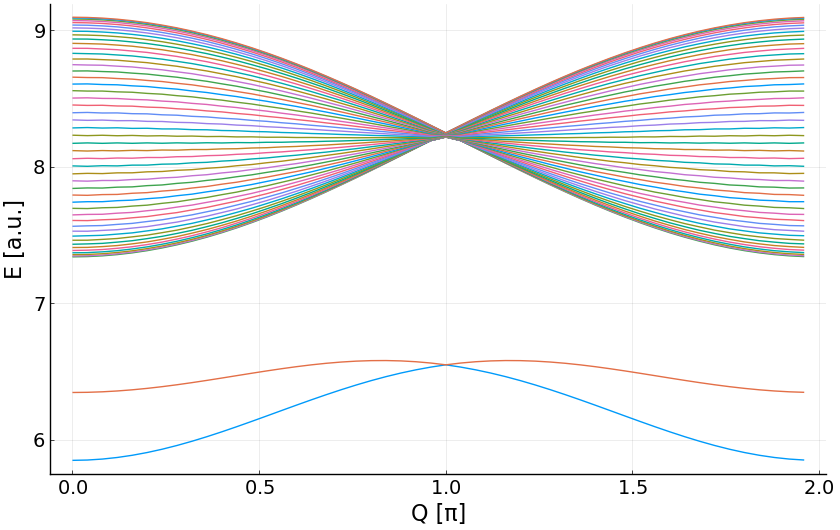

In [116]:
#  plotting dispersion
if t_fixed == true && V_fixed == true
    dispersion = zeros(Float64,N, N)
    for Q in K 
       Diag = diagonalize_H(K,Q,N,t[1],V,h)[1]
       dispersion[index(Q),:] .= real(Diag)
    end
    
    using Plots
    pythonplot()
    plot(K_vals*2/N,(dispersion), label  = "") # title = "V = $(V), t = $(t[1])",
    xlabel!("Q [π]")
    ylabel!("E [a.u.]")
end
    

In [ ]:
# preparing values for the computation of correlation functions
if t_fixed == true && V_fixed == true
    Q = Zn(0)
    prep = diagonalize_H(K,Q,N,t[1],V,h)
    Diag = prep[1]
    Vecs = prep[2]
    H = prep[3]
    E_A = prep[4]
    E_B = prep[5]
    a1 = prep[6]
    a2 = prep[7]
    b1 = prep[8]
    b2 = prep[9]

    # defining the correlation function for the excited states
    function C(X,Vecs,a1,a2,b1,b2,N,K::Vector{Zn},Q::Zn)
        M = zeros(Complex{Float64},N,N)
        for k1 in K 
            for k2 in K 
                if k1 ==k2
                    k = k1
                    M[index(k),index(k)] = (1/N^2*(AAAA(K,k,Q,a1,a2,b1,b2,X) + ABBA(K,k,Q,a1,a2,b1,b2,X) + BBAA(K,k,Q,a1,a2,b1,b2,X) + AABB(K,k,Q,a1,a2,b1,b2,X) + BAAB(K,k,Q,a1,a2,b1,b2,X) 
                    + BBBB(K,k,Q,a1,a2,b1,b2,X))
                    -nak(K,k,Q,a1,a2,b1,b2)*nbk(K,k,Q,a1,a2,b1,b2) #prefactor 1/N^2 already in the definition of nak and nbk
                    )
                else
                    M[index(k1),index(k2)] = 1/N^2*(ABBAoff(k1,k2,Q,a1,a2,b1,b2,X) + BBAAoff(k1,k2,Q,a1,a2,b1,b2,X) + AABBoff(k1,k2,Q,a1,a2,b1,b2,X) + BAABoff(k1,k2,Q,a1,a2,b1,b2,X))
            end
        end
        end
        transformed_M = Vecs' * M * Vecs  # transforming the correlation matrix as we transformed the Hamiltonian
        return diag(transformed_M), M  # returning just the diagonal elements, matrix M is not needed for the correlation function itself
    end
        
    # correlation function for every R and all eigenstates
    X_vector = collect(-div(N,2):div(N,2)-1)
    L = length(X_vector)
    correlation = zeros(Float64,L,N)
    for X in X_vector
        correlation[X+abs(minimum(X_vector))+1,:] .= real(C(X,Vecs,a1,a2,b1,b2,N,K,Q)[1])
    end
    
    #= correlation function of the ground state
    function C0(R,Vecs,a1,a2,b1,b2,N,K::Vector{Zn},Q::Zn)
        return (1/N^2*(BBBB_0(K,a1,a2,b1,b2,X) + BAAB_0(K,a1,a2,b1,b2,X)) - 1/N^2*sum(abs2(b1[index(l)]) for l in K)*sum(abs2(b2[index(l)]) for l in K)) 
    end
    C0_vec = zeros(Complex{Float64},L)
    for i in 1:length(X_vector)
        C0_vec[i] = C0(X_vector[i],Vecs,a1,a2,b1,b2,N,K,Q)
    end
    =#
    end 

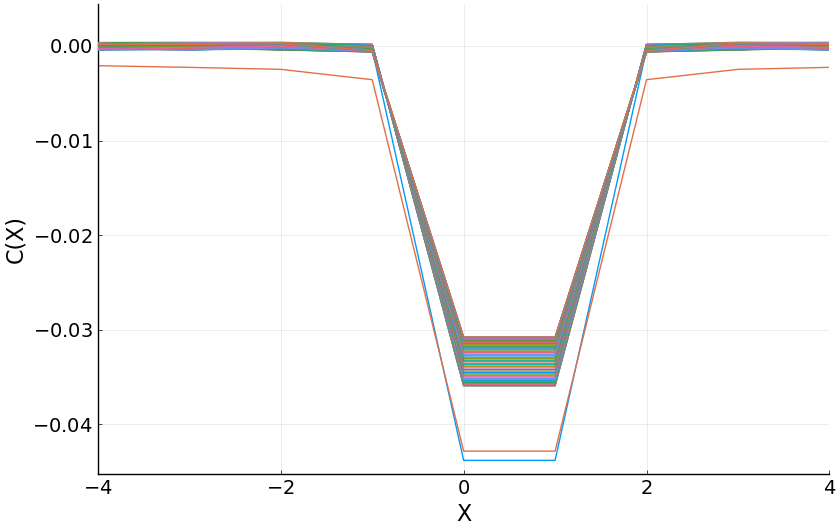

In [118]:
#  plotting the correlation function

if t_fixed == true && V_fixed == true
    using Plots
    pythonplot()
    plot(X_vector,correlation, xlabel = "X", ylabel = "C(X)", label = "") #, title = "V = $(V), t = $(t[1]), Q = $(Q.val*2/N) π"
    xlims!(-4,4)  # zooming on the symmetry axis
    end